## BO with TuRBO-1 and TS/qEI

In this tutorial, we show how to implement Trust Region Bayesian Optimization (TuRBO) [1] in a closed loop in BoTorch.

This implementation uses one trust region (TuRBO-1) and supports either parallel expected improvement (qEI) or Thompson sampling (TS). We optimize the $10D$ Ackley function on the domain $[-10, 15]^{10}$ and show that TuRBO-1 outperforms qEI as well as Sobol.

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_x -f(x)=0$.

[1]: [Eriksson, David, et al. Scalable global optimization via local Bayesian optimization. Advances in Neural Information Processing Systems. 2019](https://proceedings.neurips.cc/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf)


In [1]:
from reservoir import *
import torch
import numpy as np
import time
import pylab as pl
from IPython import display

device: cpu


In [2]:
def plot_RC(y, ypred):
    plt.figure(figsize = (16,4))
    plt.plot(ypred, label = "prediction")
    plt.plot(y, label = "test")
    plt.legend();

### Load data and train test split

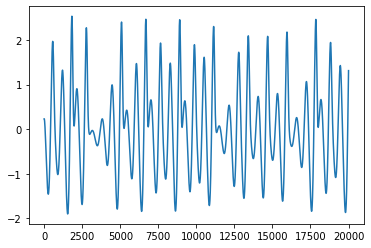

In [10]:
data = np.loadtxt('/Users/hayden/Desktop/hw6_209/data/x.dat')
data.shape
plt.plot(data)

In [11]:


tr_len = 10000
te_end = 12500 #6000

train = torch.FloatTensor(data[:tr_len].reshape(-1, 1))
test = torch.FloatTensor(data[tr_len:te_end].reshape(-1, 1))

## Train a simple RC with arbitrary hyper parameters

GENERATING IN WEIGHTS


Text(0.5, 1.0, 'RC before optimization')

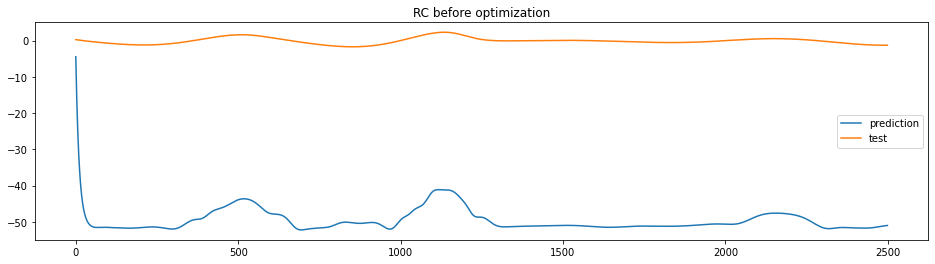

In [12]:
#n_nodes=1000, connectivity=0.01, input_scaling=0.5, feedback_scaling=0.5, leaking_rate=0.3, spectral_radius=1.25, regularization=1e-8, feedback=True)
torch.manual_seed(1)
RC = EchoStateNetwork(n_nodes=1000, connectivity=0.1, input_scaling=1, feedback_scaling=1, 
         leaking_rate=0.1, spectral_radius=0.96, regularization=1e-3, feedback=True, backprop = False, epochs = 20,
         activation_f = sinsq) #bias = -10,

RC.train( train.to(device), learning_rate = 5e-3)

err, pred = RC.test(test.to(device), scoring_method = "nrmse", steps_ahead = 1)

plot_RC(test, pred)
plt.title("RC before optimization")

## optimize

FEEDBACK: True , device: cpu
cpu
GENERATING SPARSE DICT
generated sparse reservoir library for random seed 123
generated sparse reservoir library for random seed 999
torch.Size([1000, 1]) in weights
Model initialization and exploration run...
5
timestep  0
Epoch: 1/7..  Training Loss: 456.315.. 
timestep  0
Epoch: 2/7..  Training Loss: 257.016.. 
timestep  0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 18, in <module>
  File "/Users/hayden/Desktop/RcTorch/reservoir/esn_cv.py", line 989, in optimize
    [self.eval_objective(x.view(1,-1)) for x in X_turbo], dtype=dtype, device=device).unsqueeze(-1)
  File "/Users/hayden/Desktop/RcTorch/reservoir/esn_cv.py", line 989, in <listcomp>
    [self.eval_objective(x.view(1,-1)) for x in X_turbo], dtype=dtype, device=device).unsqueeze(-1)
  File "/Users/hayden/Desktop/RcTorch/reservoir/esn_cv.py", line 617, in eval_objective
    return self.HRC(x)#unnormalize(x, self.scaled_bounds))
  File "/Users/hayden/Desktop/RcTorch/reservoir/esn_cv.py", line 881, in HRC
    RC.train(x = train_x, y = train_y,  burn_in=self.esn_burn_in, learning_rate = self.learning_rate)
  File "/Users/hayden/Desktop/RcTorch/reservoir/esn.py", line 425, in train
    _, outp

TypeError: object of type 'NoneType' has no len()

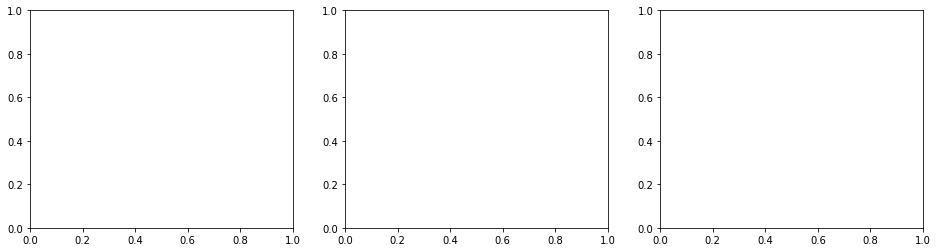

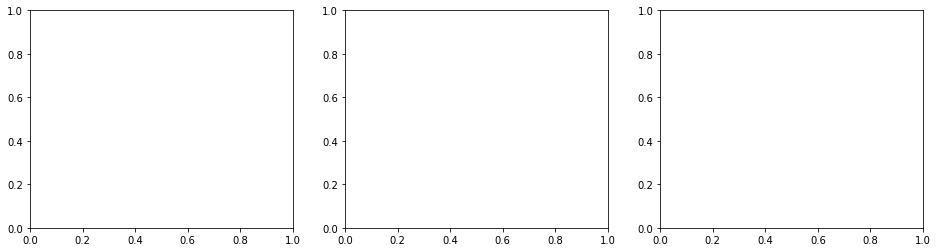

In [5]:
%%time
%matplotlib inline
#### eps isn't what it used to be.

bounds_dict = {"spectral_radius" : (0,1), 
               "connectivity" : (-5,0), 
               "regularization": (-5,-2),
               "leaking_rate" : (0, 1),
               #"feedback_scaling" : (0,1),
               #"input_scaling" : (0,1),
               "bias" : (-3,3),#"uniform",#
               "n_nodes" : 1000, 
               "feedback": 1}
esn_cv = EchoStateNetworkCV(bounds = bounds_dict, subsequence_length = 1000, esn_feedback = True,
                            steps_ahead = 1, scoring_method = "mse", interactive = True, random_seed = 123,
                            eps = 3, initial_samples = 10, approximate_reservoir = True, length_min = 2**-7,
                            batch_size = 8, backprop = True, esn_burn_in = 0, validate_fraction = 0.5,
                           activation_function = sinsq)
vals = esn_cv.optimize(train)


pl.plot(esn_cv.iteration_durations)
print(np.mean(esn_cv.iteration_durations))
vals

In [53]:
vals_ = vals.copy()
vals_["connectivity"] = 10**(vals_["connectivity"])
vals_["regularization"] = 10**(vals_["regularization"])

## Optimized RC test set score (with feedback)

Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =3.196e-05.. .regenerating
1
Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =3.196e-05.. .regenerating
2
Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =3.196e-05.. .regenerating
3
Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =3.196e-05.. .regenerating
4
Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =3.196e-05.. .regenerating
5
Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =3.196e-05.. .regenerating
6
Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =3.196e-05.. .regenerating
7
Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =3.196e-05.. .regenerating
8
Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =3.196e-05.. .regenerating
9
Loaded Reservoir is Nilpotent (max_eigenvalue =0.0), connectivity =3.196e-05.. .regenerating
10
Loaded Reservoir is Nilpotent (max_eigenvalue =0.

Text(0.5, 1.0, 'Optimized RC')

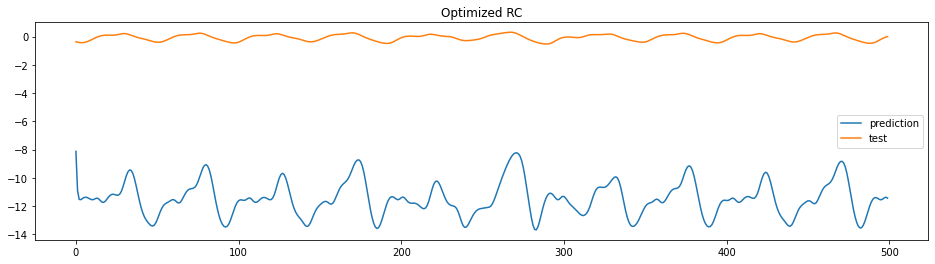

In [54]:
RC = EchoStateNetwork(**vals_, feedback=True, backprop = False, epochs = 20,
         activation_f = sinsq)
RC.train( train.to(device), learning_rate = 5e-3)

err, pred = RC.test(test.to(device), scoring_method = "nrmse", steps_ahead = 1)


plot_RC(test, pred)
plt.title("RC before optimization")
plt.title("Optimized RC")


In [8]:
assert 1 == 0

AssertionError: 

In [9]:
step = 10

err, pred = RC.test(test, scoring_method = "rmse", steps_ahead = 10)
print('reported error', err)
end = len(test)

def calc_err(steps_ahead = step, pred = pred, truth =test):
    pred, truth = pred.to("cpu"), truth.to("cpu")
    if steps_ahead == None:
        pred_, test_ = pred
    else:
        end = len(test) - steps_ahead
        pred_ = pred[ :end, steps_ahead].clone()
        test_ = test[ steps_ahead : ].clone()
    assert len(pred_) == len(test_), "[pred_ {}] neq [test {} ]".format(len(pred_), len(test_))
    return torch.mean((pred_ - test_)**2)
errors = []   
for i in range(step):
    errors.append(calc_err(i).item())
    #print(i, "error: ", )

hi = pd.DataFrame({"steps_ahead":list(range(step)), "error": errors})

reported error tensor(2.1052)


<AxesSubplot:xlabel='steps_ahead', ylabel='error'>

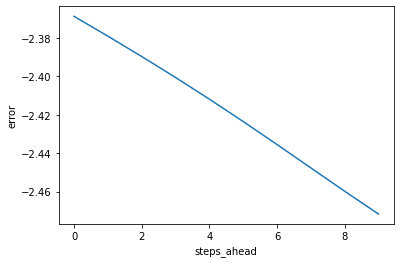

In [10]:
sns.lineplot(x = "steps_ahead", y = np.log(hi["error"]), data = hi)

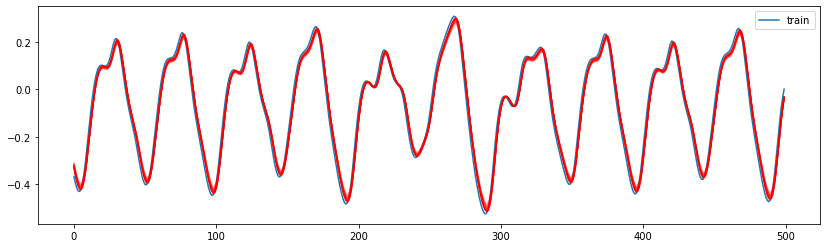

In [11]:
plt.figure(figsize = (14,4))
plt.plot(list(range(len(test))), test, label = "train")
for i in range(pred.shape[1]):
    #print(i)
    offset = [0] *(i+1)
    #yy =  offset + pred[:,i].numpy().ravel().tolist()
    yy = pred[:,i].cpu().numpy().ravel().tolist()
    
    xx = list(range(len(yy )))
    
    plt.plot(xx, yy, alpha = (1-0.1) * i, color = "red")

plt.legend()

10


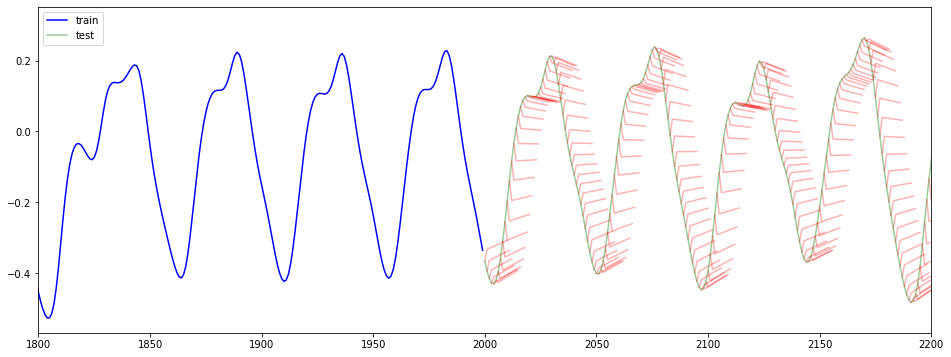

In [12]:
def my_loss_plot(x, start_loc, pred = pred):
    pred_ = pred.cpu().numpy()
    print(x.shape[1])
    train_ = train
    plt.figure(figsize = (16, 6))
    
    plt.plot(range(len(train_)), train_, color = 'blue', label = "train")
    
    plt.plot(range(len(train_), len(train_) + len(test)), test, color = "green", label = "test", alpha = 0.4)
    for i in range(200):
        plt.plot(range(len(train_)+ i, len(train_) + pred_.shape[1]+ i + 1),
                 torch.cat([test[i], torch.tensor(pred_[i,:])],0), color = "red", alpha = 0.3)
    plt.xlim(start_loc, 2200)
    
    plt.legend()
my_loss_plot(pred, 1800)


In [13]:
test.numpy()[0:3].reshape(-1,).tolist()

[-0.3674686551094055, -0.3948092460632324, -0.4158034324645996]

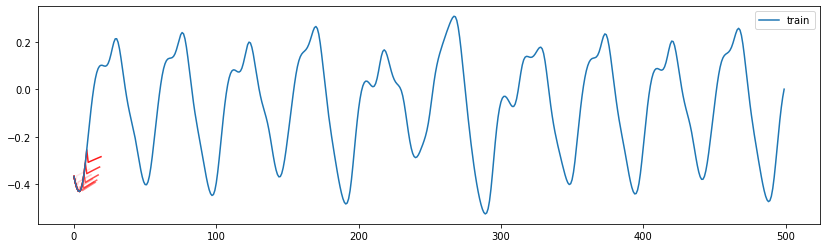

In [14]:
plt.figure(figsize = (14,4))
for i in range(pred.shape[1]):
    offset = test.numpy()[0:(i+1)].reshape(-1,).tolist()#*(i+1)
    yy = offset + pred[i,:].cpu().numpy().ravel().tolist()
    
    xx = list(range(len(yy )))
    
    plt.plot(xx, yy, alpha = 0.1 * i, color = "red")
    #if i >5:
    #    break
plt.plot(list(range(len(test))), test, label = "train")
plt.legend()

<AxesSubplot:>

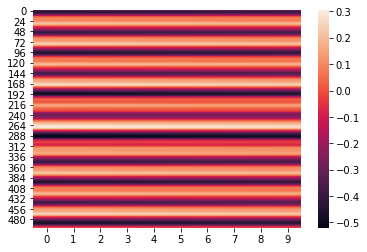

In [15]:
sns.heatmap(pred.cpu())

In [16]:
_, pred__ = RC.test(train, scoring_method = "mse", steps_ahead = 1)
pred__.shape

torch.Size([2000, 1])

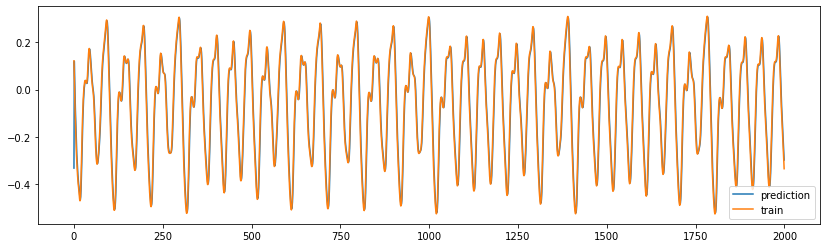

In [17]:
hi = pred__.cpu().numpy().ravel()
plt.figure(figsize = (14,4))
plt.plot(list(range(len(hi))), hi, label = "prediction")
plt.plot(list(range(len(hi))), train, label = "train")
plt.legend()

In [18]:
def convert_bounds(bounds_dict):
    """
    This function converts the bounds of a dictionary.
    """
    var_list = ["spectral_radius", "connectivity", "regularization", "leaking_rate", "bias"]
    log_params = ["connectivity", "regularization"]
    for i, param in enumerate(var_list):
        lb, ub = bounds_dict[param]
        tens_ = torch.cat([torch.tensor(lb).view(1,1), torch.tensor(ub).view(1,1)], dim = 0)
        if not i:
            tensor_ = tens_
        else:
            tensor_ = torch.cat([tensor_, tens_], 1)
    print('tensor', tensor_)
    return(tensor_)
    # build bound tensor:
        
    

In [19]:
def get_free_memory():
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0) 
    a = torch.cuda.memory_allocated(0)
    f = r-a  # free inside reserved
    return(f)
#torch.cuda.empty_cache()
#get_free_memory()

In [20]:
torch.cuda.device_count()

0

<AxesSubplot:>

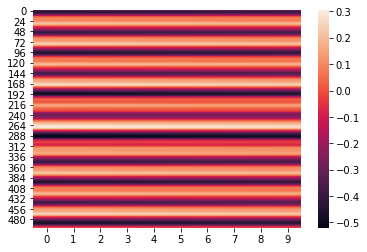

In [21]:
sns.heatmap(pred.cpu().numpy())

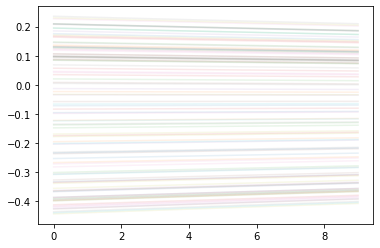

In [22]:
#plt.plot(pred.cpu().numpy())
pred_ = pred.cpu().numpy().copy()
for i in range(100):
    plt.plot(pred_[i,:], alpha = 0.1)

### Later: multiprocessing

%%time
import torch.multiprocessing as mp
#from torch.multiprocessing import Pool, Process, set_start_method
#from model import MyModel

def bs_func(tensor1, tensor2):
    tensor3 = tensor1 * tensor2
    return tensor3
num_processes = 2
processes = []
for rank in range(num_processes):
    p = mp.Process(target =bs_func, args=([1, 2],[2, 3],[3, 4],[4, 5],[5, 6]))
    p.start()
    processes.append(p)
for p in processes:
    p.join()
processes

In [23]:
%%time
def train_(x):
    for i in range(1000):
        torch.rand(100, 100) @ torch.rand(100, 100)
    print("dome" + str(x))
    #return 3
train_(3)

dome3
CPU times: user 114 ms, sys: 1.49 ms, total: 116 ms
Wall time: 114 ms


In [24]:
from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
except RuntimeError:
    print("fail")
    pass

In [28]:
def get_best_params():
    
    best_normalized_params = X_turbo[Y_turbo.numpy().argmax()].view(1,-1)
    best_params = unnormalize(best_normalized_params, HRC.bounds)
    #spectr, connect, regul, leak_rate, bias = parameterization[i, :]
    best_params_dict = {}
    param_list = "spectral_radius", "connectivity", "regularization", "leaking_rate", "bias" 
    exp_params = "connectivity", "regularization"
    
    best_params_dict = { param_list[i] : best_params[0,i].item() for i in range(len(param_list))}
    
    for log_param in exp_params:
        best_params_dict[log_param] = 10 ** best_params_dict[log_param]
        
   
    return best_params_dict
best_params = get_best_params()

NameError: name 'X_turbo' is not defined

In [29]:
#tr_len = 4000
te_end = 4600 #6000

#train = torch.FloatTensor(data[:tr_len].reshape(-1, 1))
test = torch.FloatTensor(data[tr_len:te_end].reshape(-1, 1))

In [30]:
RC = esn(**best_params, feedback=True, backprop = False) #bias = -10,
_ = RC.train( train)

NameError: name 'best_params' is not defined

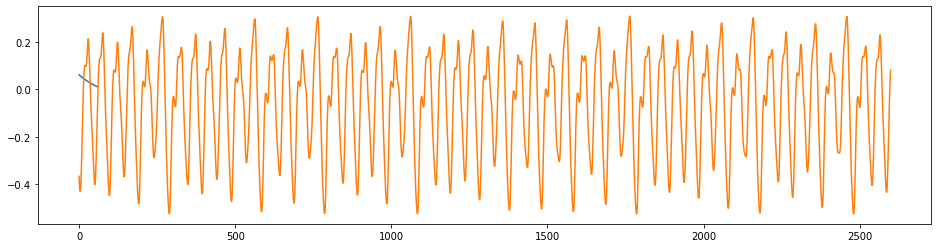

In [31]:
err, pred_ = RC.test(test, scoring_method = "mse", steps_ahead = 60)
pl.figure(figsize = (16,4))
pl.plot(pred_[len(pred_) - 1,:])
pl.plot(test)


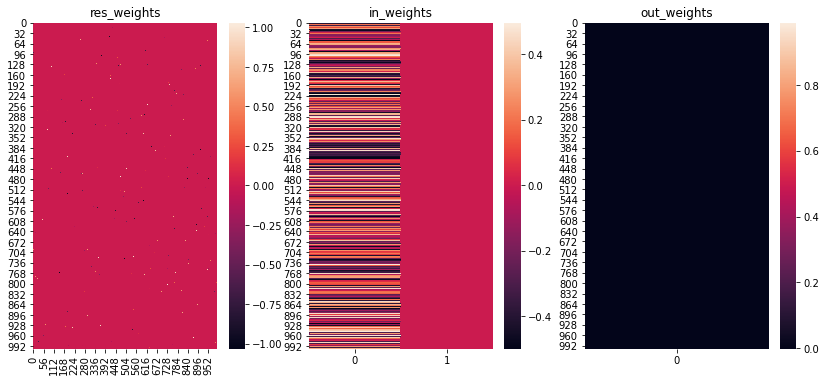

NameError: name 'RC' is not defined

<Figure size 1008x288 with 0 Axes>

In [32]:
fig, axs = plt.subplots(1,3, figsize = (14,6))

plt.sca(axs[0]); RC.display_res_weights(); plt.title("res_weights")
plt.sca(axs[1]); RC.display_in_weights(); plt.title("in_weights")
plt.sca(axs[2]); RC.display_out_weights(); plt.title("out_weights")

plt.show()
plt.figure(figsize = (14, 4))
RC.plot_states()
plt.title("states")
plt.show()

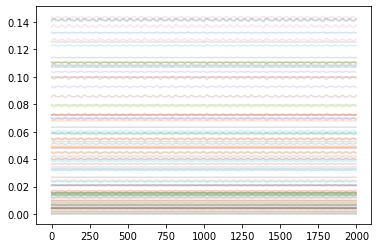

In [43]:
for i in range(100): #range(RC.state.shape[1]):
    pl.plot(RC.state[:,i], alpha = 0.2)